<a href="https://colab.research.google.com/github/hegxiten/ECE561MachineVision/blob/master/HW5_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Use the testing mode for evaluation (the whole ready-to-go model), since we 
# are not contributing to the model itself
# If user would like to use this acceleration, select the menu option 
# "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and
# click "SAVE"

%matplotlib inline
import torch,os,torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision import datasets, models, transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop, Grayscale

from tqdm.autonotebook import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from PIL import Image

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
# Upload kaggle API key file
uploaded = files.upload()
# moved 

Saving kaggle.json to kaggle (1).json
'kaggle (1).json'   kaggle.json   sample_data/


In [12]:
# Mount Google Drive to access pictures
from google.colab import drive
drive.mount('/content/gdrive')
# Check if Google Drive is mounted
%cd /content/gdrive
%ls
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/HW5_files/dogs-vs-cats/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive
'My Drive'/
/content/gdrive/My Drive/Colab Notebooks/HW5_files/dogs-vs-cats


In [0]:
# Download data for the nyc_taxi_trip_duration challenge
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 34.0MB/s]
 97% 263M/271M [00:09<00:00, 48.1MB/s]
100% 271M/271M [00:10<00:00, 27.8MB/s]
 96% 521M/543M [00:15<00:01, 22.3MB/s]
100% 543M/543M [00:15<00:00, 36.1MB/s]


In [0]:
# Fetch 10 different customized images from mounted Google Drive, 
import os
root_path = '/content/gdrive/My Drive/Colab Notebooks/HW5_files/dogs-vs-cats/'
traindir = root_path + 'train/'
testdir = root_path + 'test1/'

trainfiles = os.listdir(traindir)
testfiles = os.listdir(testdir)

In [0]:
class CatDogDataset(Dataset):
    def __init__(self, filelist, root_dir, transform=None):
        self.filelist = filelist
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, idx):
        img_name = self.filelist[idx]
        fullname = os.path.join(self.root_dir, img_name)
        image = Image.open(fullname)
        if "cat" in img_name:
            cls = 0
        elif "dog" in img_name:
            cls = 1
        else:
            raise Exception("Input Image Not Labelled Correctly")
        if self.transform:
            image = self.transform(image)
        return [image, cls]

def get_data_loaders(train_batch_size=256, val_batch_size=64):    
    # Ugly method to hardcode convert 1 channel grayscale to 3 channel RGB-like
    # but it is still gray input (due to MNIST from torchvision) 
    # See https://discuss.pytorch.org/t/how-to-get-mnist-data-from-torchvision-with-three-channels-for-some-pretrained-model-like-vgg/21872
    data_transform = Compose([Resize((224,224)),
                              CenterCrop(224),
                              ToTensor(), 
                              Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])])

    train_loader = DataLoader(CatDogDataset(trainfiles, 
                                            traindir, 
                                            transform=data_transform),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(CatDogDataset(trainfiles, 
                                          traindir, 
                                          transform=data_transform),
                            batch_size=val_batch_size, shuffle=False)
    # use the train dataset for both train and validation (no labels on testset)
    return train_loader, val_loader

def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [0]:
model_1 = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)

NUM_CLASS = 2
in_fc_nums = model_1.fc.in_features #resnet18 number of the last input neurons
fc = nn.Linear(in_fc_nums,  NUM_CLASS)
model_1.fc = fc


epochs = 5
train_loader, val_loader = get_data_loaders()# put your data loader here
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, try Adam this time to have a tast
# optimize the full connection layer only, magic numbers from online resource
optimizer = optim.Adam(model_1.fc.parameters(), lr=0.001, betas=(0.9, 0.999))

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model_1.cuda()

losses = []

batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model_1.train()
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model_1.zero_grad()
        outputs = model_1(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model_1.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            # Get's the prediction (outputs) from the network
            outputs = model_1(X) 

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(calculate_metric(metric, 
                                            y.cpu(), predicted_classes.cpu()))
    print(confusion_matrix(y.cpu(), predicted_classes.cpu()))
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.7MB/s]


NameError: ignored

In [0]:
model_2 = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
NUM_CLASS = 2
in_fc_nums = model_2.fc.in_features #resnet18 number of the last input neurons
fc = nn.Linear(in_fc_nums,  NUM_CLASS)
model_2.fc = fc

epochs = 5
train_loader, val_loader = get_data_loaders()# put your data loader here
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, try Adam this time to have a tast
# optimize the full connection layer only, magic numbers from online resource
optimizer = optim.Adam(model_2.fc.parameters(), lr=0.001, betas=(0.9, 0.999))

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_2.cuda()

losses = []

batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model_2.train()
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model_2.zero_grad()
        outputs = model_2(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model_2.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            # Get's the prediction (outputs) from the network
            outputs = model_2(X) 

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(calculate_metric(metric, 
                                            y.cpu(), predicted_classes.cpu()))
    print(confusion_matrix(y.cpu(), predicted_classes.cpu()))
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Predict Label is: [tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(3, device='cuda:0'), tensor(9, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(5, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(3, device='cuda:0'), tensor(8, device='cuda:0'), tensor(9, device='cuda:0'), tensor(4, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(5, device='cuda:0'), tensor(4, device='cuda:0'), tensor(3, device='cuda:0'), tensor(4, device='cuda:0'), tensor(7, device='cuda:0'), tensor(1, device='cuda:0'), tensor(7, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Confusion Matrix for 10 digits from a random 200-sample validation set
[[20  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  1]
 [ 0  0  0  0  0 13  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  1  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0 19  0]
 [ 0  0  0  0  0  0  0  0  0 19]]

 The validation set images


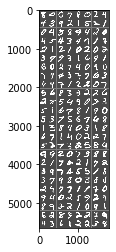

In [0]:
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
mnist = MNIST(download=True, train=True, root=".").train_data.float()
data_transform = Compose([Resize((224,224)),
                          Grayscale(3),
                          ToTensor(), 
                          Normalize((mnist.mean()/255,), 
                                    (mnist.std()/255,))])
data_loader_test = DataLoader(dataset=MNIST(download=True, root=".", 
                                            transform=data_transform, train=True),
                              batch_size = 200,
                              shuffle = True)
X_test, y_test = next(iter(data_loader_test))
inputs = Variable(X_test.to(device))
pred = model(inputs)
_,pred = torch.max(pred, 1)
print("Predict Label is:", [ i for i in pred.data])
print("Real Label is:",[i for i in y_test])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print("\nConfusion Matrix for 10 digits from a random 200-sample validation set")
print(confusion_matrix(y_test, pred.cpu()))
print("\n The validation set images")
plt.imshow(img)
